In [1]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,save,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import imshow,plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca,savefig

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra
from src.xrd_data import DataXRD

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]
lazurite = database['Lazurite'][0]

In [3]:
xrd_data = DataXRD().load_h5('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5')

Loading: /home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5
Load inverted
Load convoluted


In [4]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [5]:
files = glob('Profilo/Lazurite/roi*.dat')
phase = MixPhase([calcite])

xrd_gauss_newton = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M0795/CappelloGialloXRD/calibration.ini')
    spectra.convolve(4).raw_snip(m=32)
    
    xrd_gauss_newton += [GaussNewton(phase,spectra)]

(0.0, 1280.0)

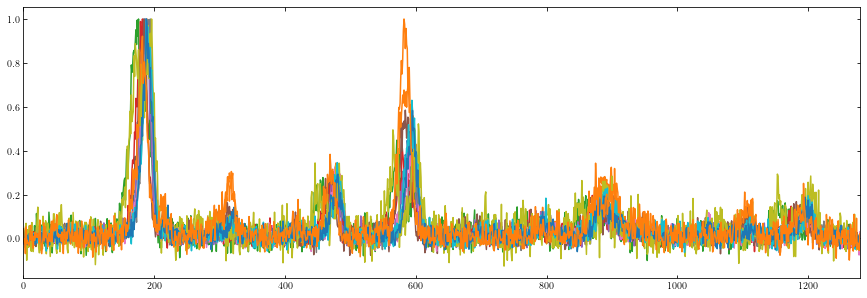

In [6]:
figure(figsize=(15,5))
for g in xrd_gauss_newton:
    plot(g.spectra.intensity)
xlim(0,1280)

[-1183.8760432361464, 51.00000000000024, 1973.7322135867914] 22.092294065205728
[-1181.685627186276, 51.0, 1872.44009211553] 19.163951737217626
[-1199.5358211193131, 51.000000000000476, 1932.451164503551] 9.402716591728963
[-1138.4495523752178, 50.99999999999779, 1687.7791242159267] 17.619718280797567
[-1199.4208933502005, 50.99999999999839, 2015.058299454408] 18.91279337213688
[-1182.0709104442246, 51.000000000000476, 1885.1435205063542] 8.777446679779857
[-1181.5966394449813, 51.00000000000131, 1872.1966976896977] 6.775377224252297
[-1152.575691994285, 51.000000000002274, 1697.3428810133953] 14.955372674236422
[-1199.094617055042, 50.99999999999989, 1913.372938840779] 18.562747448291436
[-1154.5707343480985, 51.000000000000036, 1763.1940167578243] 19.861097620330963
[-1164.8401808309745, 50.9999999999999, 1734.5880530051643] 16.509141058282278
[-1186.7524784107657, 50.99999999999863, 1895.4131350436367] 22.946902899829407


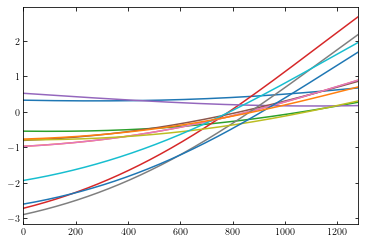

In [7]:
x = arange(1280)
    
for g in xrd_gauss_newton:
    
    g.spectra.opt = [-1186.106076632754, 51., 1954.6937605682037]
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
        
    for _ in range(4):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    print(g.spectra.opt,g.dz)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

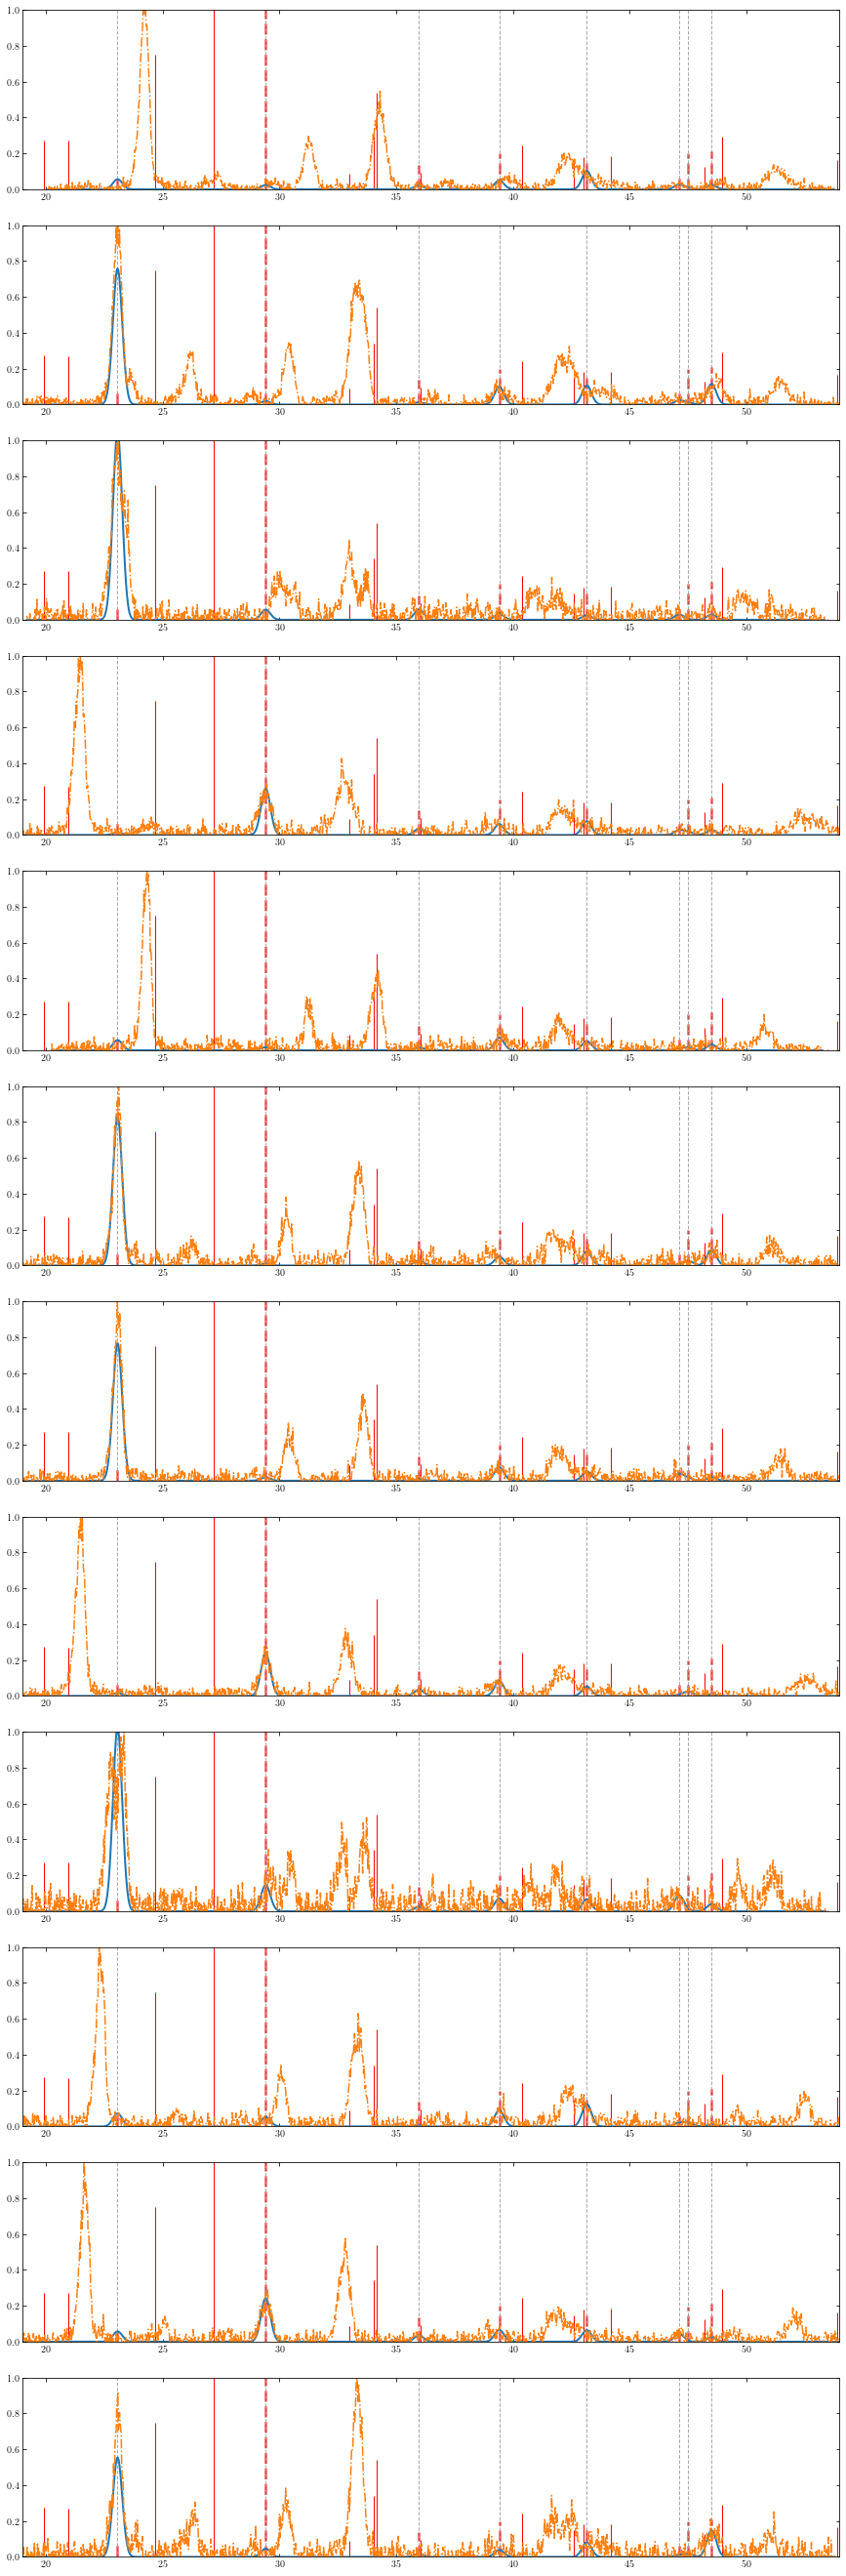

In [8]:
%matplotlib inline
fig,ax = subplots(len(xrd_gauss_newton),1,figsize = (15,48))

for i,g in enumerate(xrd_gauss_newton):
    
    g.spectra.opt = g.opt.copy()
    s = g.spectra
    
    t,r = hydrocerussite.get_theta()
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(t,0,r,'r',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [14]:
%%time

data = xrd_data.inverted.reshape(-1,1280)
profilo_gauss_newton = []

for d in data[:]:
    spectra = Spectra()
    spectra.from_array(d)
    spectra.opt[:] = array([-1185.2366578999117, 50.99999999999997, 1955.6511408474753])
    spectra.convolve(4).raw_snip(m=32)
    
    g = GaussNewton(phase,spectra)
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
        
    for _ in range(2):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    #print(g.spectra.opt)
    
    profilo_gauss_newton += [g]
    

CPU times: user 3min 24s, sys: 25.9 ms, total: 3min 24s
Wall time: 3min 24s


In [35]:
%%time
for g in profilo_gauss_newton:
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

CPU times: user 1min 57s, sys: 5.55 ms, total: 1min 57s
Wall time: 1min 57s


In [15]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)

In [30]:
f = (a > -1150)
out[f] = 100

In [33]:
f = (xrd_data.inverted[:,:,185] < 50)
out[f] = 100

In [34]:
out.shape,xrd_data.inverted.shape

((95, 170), (95, 170, 1280))

In [16]:
out.max(),out.min()
save('Calcite.npy',out)

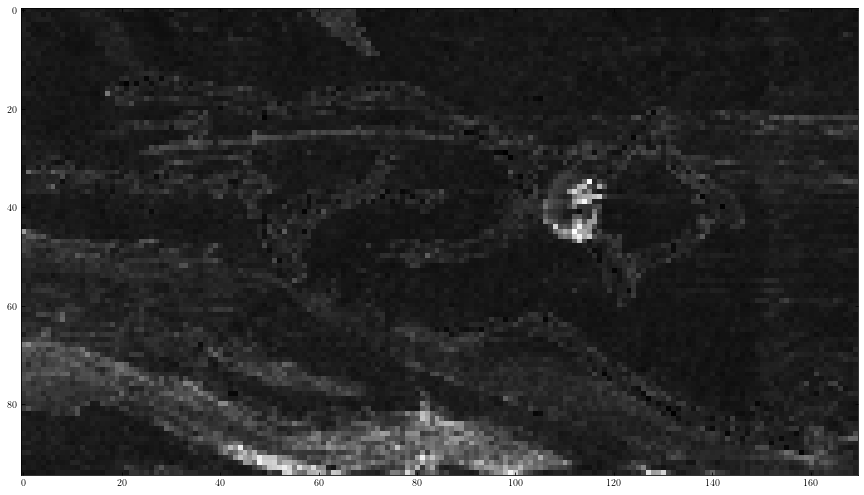

In [18]:
figure(figsize=(15,15))
imshow(out[::-1],cmap='gray')
savefig('Calcite_loss.png')

4.737620116483244


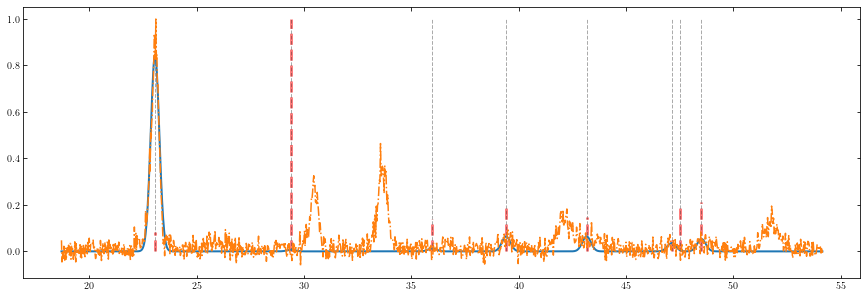

In [19]:
figure(figsize=(15,5))
g = profilo_gauss_newton[out.argmin()]
s =g.spectra

for _ in range(64):
    g.calibration_nobeta()
print(g.dz)
    
vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)

In [20]:
a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.argmin()

(-1112.1043958372668, 15368)

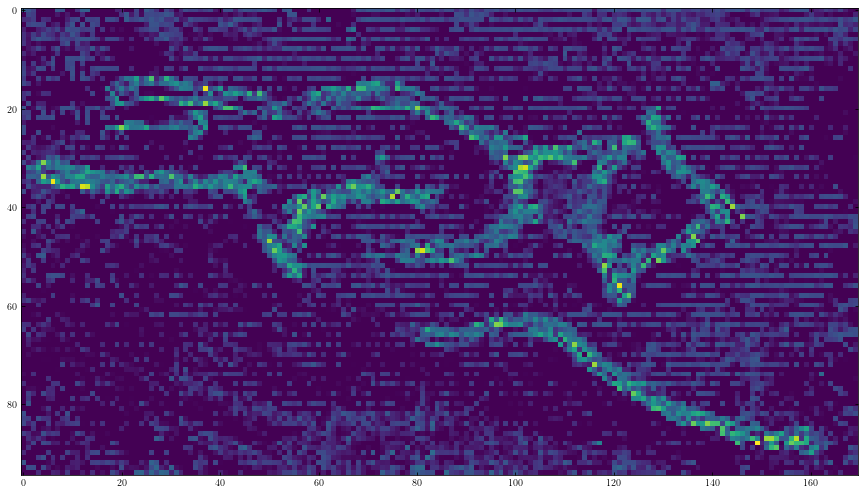

In [21]:
%matplotlib inline
figure(figsize=(15,15))
imshow(a[::-1],vmin=-1200)